<a href="https://colab.research.google.com/github/billcai/mmclassify-tutorial/blob/master/food_model_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Food Model Classifier

## Downloading data
First, we download the Food-101 dataset that is open-sourced by ETH Zurich.'

We are using libraries [mmclassification](https://github.com/open-mmlab/mmclassification) which is built on PyTorch.

We are also using Google Colab (thank you Google for free compute). But please read the [FAQs](https://research.google.com/colaboratory/faq.html) and be a considerate member of the community.

In [1]:
# installing dependencies
!pip install mmcv
!git clone https://github.com/open-mmlab/mmclassification.git && cd mmclassification && pip install -e .
!pip install wget
import sys, os
sys.path.append(os.path.join(os.getcwd(),'mmclassification'))

     |████████████████████████████████| 317kB 11.1MB/s 
     |████████████████████████████████| 194kB 21.1MB/s 
  Created wheel for mmcv: filename=mmcv-1.3.7-py2.py3-none-any.whl size=447834 sha256=e9fddd70831e8095a25578030317184a2682221239db8dca0481c6e18db07524
  Stored in directory: /root/.cache/pip/wheels/f6/3e/e4/62443b46faad6c16893cd124a3beafa4313d1e33fae12c0442
Successfully built mmcv
Cloning into 'mmclassification'...
remote: Enumerating objects: 2787, done.
remote: Counting objects: 100% (1079/1079), done.
remote: Compressing objects: 100% (430/430), done.
remote: Total 2787 (delta 873), reused 653 (delta 649), pack-reused 1708
Receiving objects: 100% (2787/2787), 2.69 MiB | 6.71 MiB/s, done.
Resolving deltas: 100% (1781/1781), done.
Obtaining file:///content/mmclassification
  Running setup.py develop for mmcls
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=3436eb080c681bd699673acfcbd2b21e695f09a8893cef48560ce09500baf254
  Stored in directory: /

In [2]:
import wget
# downloading dataset with wget
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
if 'dataset.tar.gz' not in os.listdir(os.getcwd()):
  wget.download(url, 'dataset.tar.gz')

## Unzipping dataset
We use tarfile to unzip the dataset

In [3]:
# unzipping dataset
import tarfile
if 'food-101' not in os.listdir(os.getcwd()):
  fname = 'dataset.tar.gz'
  tar = tarfile.open(fname, "r:gz")
  tar.extractall()
  tar.close()

## Visualize dataset
First, we inspect the dataset, and visualise the images

In [4]:
!apt-get install -y tree
!tree food-101 -L 2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (721 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
food-101
├── images
│   ├── apple_pie
│   ├── baby_back_ribs
│   ├── baklava
│   ├── beef_carpaccio
│   ├── beef_tartare
│   ├── beet_salad
│   ├── beignets
│   ├── bibimbap
│   ├── bread_pudding
│   ├── breakfast_burrito
│   ├── bruschetta
│   ├── caesar_salad
│   ├── cannoli
│ 

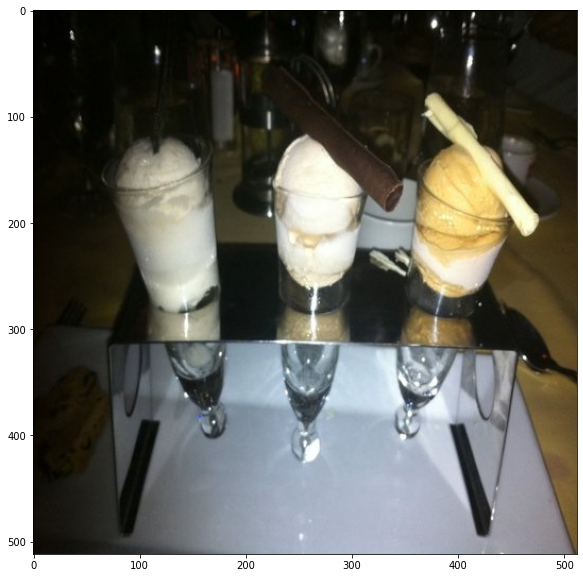

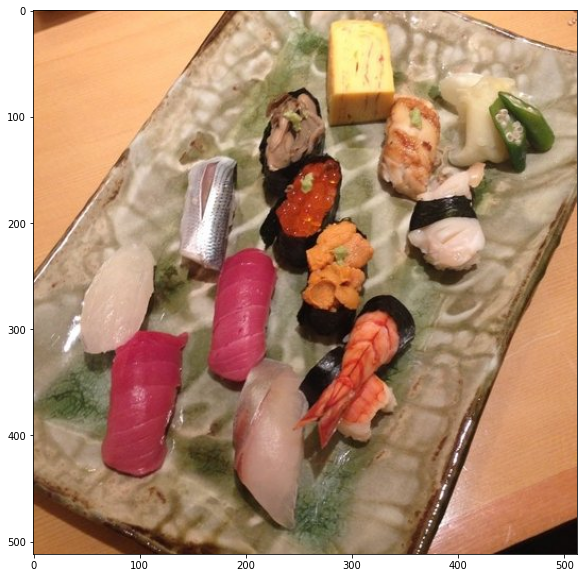

In [5]:
import mmcv
import matplotlib.pyplot as plt
import os 
%matplotlib inline 

cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'food-101','images')
icecream_dir = os.path.join(image_dir,'ice_cream')
sashimi_dir = os.path.join(image_dir,'sashimi')
for food_type in [icecream_dir,sashimi_dir]:
    filename = os.listdir(food_type)[0]
    img = mmcv.imread(os.path.join(food_type,filename))
    plt.figure(figsize=(15, 10))
    plt.imshow(mmcv.bgr2rgb(img))
    plt.show()

## Data Format
We want to use the [mmclassification](https://github.com/open-mmlab/mmclassification) library provided by [OpenMMLab](https://github.com/open-mmlab). 

Based on the [docs](https://mmclassification.readthedocs.io/en/latest/index.html), we need to convert the dataset to the Imagenet classification format. The Imagenet classification format has training data in:
```
train
    label_1/
        XXXX.jpg
        ...
    label_2/
        YYYY.jpg
        ...
    ...
```
And validation data in the form of:
```
val
    XXXX.jpg
    YYYY.jpg
```
Along with a text file, e.g. `val_imagenet.txt` in the form of:
```
XXXX.jpg 0
YYYY.jpg 1
```
With the second value as the class index (which should match the alphabetically sorted `label_1`,`label_2`,...etc. folder names of the train dataset.

The Food101 dataset already has images in the train format for Imagenet. We need to extract all test/val datasets from the Food101 image dataset, put them in a `val` folder, and create a text file with the path to the image and the class index 

In [6]:
import os
CLASSES = {}
classes_file = os.path.join(cur_dir,'food-101','meta','classes.txt')
with open(classes_file) as f:
    for count,x in enumerate(f.readlines()):
        CLASSES[x[:-1]] = count

In [7]:
import shutil
test_labels = os.path.join(cur_dir,'food-101','meta','test.txt')
test_dir = os.path.join(cur_dir,'food-101','test')
os.makedirs(test_dir,exist_ok=True)

test_samples = []
new_test_labels = os.path.join(cur_dir,'food-101','meta','test_imagenet.txt')
with open(test_labels) as f:
    for x in f.readlines():
        image_location = os.path.join(image_dir,x[:-1]+'.jpg')
        new_location = os.path.join(test_dir,x[:-1]+'.jpg')
        os.makedirs(os.path.dirname(new_location),exist_ok=True)
        if os.path.exists(image_location):
          shutil.move(
              image_location,
              new_location
          )
        test_samples.append(
            new_location+' '+str(CLASSES[x.split('/')[0]])
        )

### Review size of datasets
We use the following commands to check the size of the validation and training datasets

In [8]:
!find food-101/test -type f | wc -l

25250


In [9]:
!find food-101/images -type f | wc -l

75750


In [10]:
#Write the collected metadata of the validation dataset 
#into the format required by mmclassification
with open(new_test_labels,'w') as f:
    f.write('\n'.join(test_samples) + '\n')

In [11]:
#Double-check that the text file is as expected
!head -n 10 food-101/meta/test_imagenet.txt

/content/food-101/test/apple_pie/1011328.jpg 0
/content/food-101/test/apple_pie/101251.jpg 0
/content/food-101/test/apple_pie/1034399.jpg 0
/content/food-101/test/apple_pie/103801.jpg 0
/content/food-101/test/apple_pie/1038694.jpg 0
/content/food-101/test/apple_pie/1047447.jpg 0
/content/food-101/test/apple_pie/1068632.jpg 0
/content/food-101/test/apple_pie/110043.jpg 0
/content/food-101/test/apple_pie/1106961.jpg 0
/content/food-101/test/apple_pie/1113017.jpg 0


## Training Configuration
This training configuration is edited based on the `train.py` file provided by mmclassification (see [here](https://github.com/open-mmlab/mmclassification/blob/master/tools/train.py)).

In [12]:
from mmcv import Config, DictAction
from mmcls.apis import set_random_seed, train_model
from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.utils import collect_env, get_root_logger

### Model choice
This is a complex topic, so we will not cover much here beyond what you need to know to train a model.

#### Model Zoo
Most libraries would have a model zoo, which is a collection of implemented architectures/layers/models. The model zoo often comes with pretrained weights on some established benchmark dataset. For our problem, we are dealing with image classification - the benchmark dataset is usually [ImageNet](https://en.wikipedia.org/wiki/ImageNet). For mmclassification, the model zoo can be found [here](https://github.com/open-mmlab/mmclassification/blob/master/docs/model_zoo.md).

Generally, model zoos show important characteristics that define "performance" or "complexity" of a model. Params (M) indicates the number of learnable parameters (in millions). FLOPs (G) indicates the number of floating point operations usually for a single forward pass for a single image. Top-N (%) indicates the accuracy of classification of the model over the test dataset, taking the top N classifications. This means if given a sample image of ice cream, the model guesses (1) apple pie, (2) sashimi, (3) ice cream. The Top-1 accuracy is 0%, but the Top-3 accuracy is 100%.

We choose ShuffleNet which is a computationally cheap network, designed to run on mobile devices, that is fairly accurate. Check out this [writeup](https://medium.com/syncedreview/shufflenet-an-extremely-efficient-convolutional-neural-network-for-mobile-devices-72c6f5b01651) for cool explanation and the original [paper](https://arxiv.org/abs/1707.01083) and the ShuffleNetV2 [paper](https://arxiv.org/abs/1807.11164).

In [13]:
cfg = Config.fromfile(
    'mmclassification/configs/shufflenet_v2/shufflenet_v2_1x_b64x16_linearlr_bn_nowd_imagenet.py')

Here, we utilise the dataset that we just built, replacing the default ImageNet values

In [14]:
new_test_labels = os.path.join(cur_dir,'food-101','meta','test_imagenet.txt')
cfg.data.train.data_prefix = image_dir
cfg.data.val.data_prefix = '/'
cfg.data.val.ann_file = new_test_labels
cfg.data.test.data_prefix = '/'
cfg.data.test.ann_file = new_test_labels
cfg.data.samples_per_gpu = 384

In [21]:
cfg.model

{'backbone': {'type': 'ShuffleNetV2', 'widen_factor': 1.0},
 'head': {'in_channels': 1024,
  'loss': {'loss_weight': 1.0, 'type': 'CrossEntropyLoss'},
  'num_classes': 1000,
  'topk': (1, 5),
  'type': 'LinearClsHead'},
 'neck': {'type': 'GlobalAveragePooling'},
 'type': 'ImageClassifier'}

We see that we need to replace the num_classes to 101, instead of 1000 (number of classes for ImageNet)

In [22]:
cfg.model.head.num_classes = 101

In [23]:
import os.path as osp
import time
cfg.work_dir = 'food-101-workdir'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
cfg.dump(osp.join(cfg.work_dir, 'shufflenet_food101.config'))
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

We start training the model from the model pretrained on ImageNet, rather than starting from scratch.

In [24]:
!wget https://download.openmmlab.com/mmclassification/v0/shufflenet_v2/shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth

--2021-06-22 00:58:23--  https://download.openmmlab.com/mmclassification/v0/shufflenet_v2/shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9238066 (8.8M) [application/octet-stream]
Saving to: ‘shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth’

shufflenet_v2_batch 100%[===================>]   8.81M  6.07MB/s    in 1.5s    

2021-06-22 00:58:27 (6.07 MB/s) - ‘shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth’ saved [9238066/9238066]



In [25]:
cfg.resume_from = os.path.join(
    os.getcwd(),
    'shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth'
)

In [26]:
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info

2021-06-22 00:58:31,478 - mmcls - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.10 (default, May  3 2021, 02:48:31) [GCC 7.5.0]
CUDA available: True
GPU 0: Tesla K80
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.9.0+cu102
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.5
  - Magma 2.5.2
  - Build settings: BLAS_INF

In [27]:
logger.info(f'Config:\n{cfg.pretty_text}')
model = build_classifier(cfg.model)
model.init_weights()

2021-06-22 00:58:40,203 - mmcls - INFO - Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(type='ShuffleNetV2', widen_factor=1.0),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=101,
        in_channels=1024,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, 5)))
dataset_type = 'ImageNet'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224, backend='pillow'),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='ToTensor', keys=['gt_label']),
    dict(type='Collect', keys=['img', 'gt_label'])
]
test_pipeline = [
    dict(type='Loa

In [28]:
import copy
datasets = [build_dataset(cfg.data.train)]
val_dataset = copy.deepcopy(cfg.data.val)
val_dataset.pipeline = cfg.data.train.pipeline
datasets.append(build_dataset(val_dataset))

In [29]:
cfg.gpu_ids=range(1)
cfg.seed = None
meta['seed'] = None

In [30]:
cfg.lr_config = dict(policy='step', gamma=0.98, step=1)
# the epochs of the pretrained model is at 300, so we only train for
# 10 additional epochs (310 = 300+10)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=310)

In [31]:
cfg.workflow = [('train', 1),('val',1)]

In [ ]:
train_model(
        model,
        datasets,
        cfg,
        distributed=False,
        validate=True,
        timestamp=timestamp,
        device='cuda',
        meta=meta)

2021-06-22 00:59:06,326 - mmcls - INFO - load checkpoint from /content/shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth
2021-06-22 00:59:06,328 - mmcls - INFO - Use load_from_local loader
2021-06-22 00:59:06,439 - mmcls - WARNING - The model and loaded state dict do not match exactly

size mismatch for head.fc.weight: copying a param with shape torch.Size([1000, 1024]) from checkpoint, the shape in current model is torch.Size([101, 1024]).
size mismatch for head.fc.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([101]).
2021-06-22 00:59:06,443 - mmcls - INFO - resumed epoch 300, iter 375600
2021-06-22 00:59:06,446 - mmcls - INFO - Start running, host: root@7dac56ea45a8, work_dir: /content/food-101-workdir
2021-06-22 00:59:06,452 - mmcls - INFO - workflow: [('train', 1), ('val', 1)], max: 310 epochs
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated API

[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 97.6 task/s, elapsed: 259s, ETA:     0s

2021-06-22 01:13:28,826 - mmcls - INFO - Saving checkpoint at 301 epochs
2021-06-22 01:13:28,904 - mmcls - INFO - Epoch(val) [301][66]	accuracy_top-1: 36.8436, accuracy_top-5: 65.5208
2021-06-22 01:16:48,582 - mmcls - INFO - Epoch(val) [301][66]	loss: 3.5664
2021-06-22 01:22:18,832 - mmcls - INFO - Epoch [302][100/198]	lr: 1.143e-03, eta: -8 days, 4:40:06, time: 3.295, data_time: 2.551, memory: 7174, loss: 3.4082


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 95.5 task/s, elapsed: 264s, ETA:     0s

2021-06-22 01:31:58,140 - mmcls - INFO - Saving checkpoint at 302 epochs
2021-06-22 01:31:58,205 - mmcls - INFO - Epoch(val) [302][66]	accuracy_top-1: 48.5109, accuracy_top-5: 75.7584
2021-06-22 01:35:20,102 - mmcls - INFO - Epoch(val) [302][66]	loss: 2.7628
2021-06-22 01:40:47,548 - mmcls - INFO - Epoch [303][100/198]	lr: 1.120e-03, eta: -8 days, 21:47:40, time: 3.267, data_time: 2.535, memory: 7174, loss: 2.7673


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 93.8 task/s, elapsed: 269s, ETA:     0s

2021-06-22 01:50:46,892 - mmcls - INFO - Saving checkpoint at 303 epochs
2021-06-22 01:50:46,954 - mmcls - INFO - Epoch(val) [303][66]	accuracy_top-1: 53.7545, accuracy_top-5: 79.5604
2021-06-22 01:54:10,112 - mmcls - INFO - Epoch(val) [303][66]	loss: 2.3829
2021-06-22 01:59:36,375 - mmcls - INFO - Epoch [304][100/198]	lr: 1.098e-03, eta: -7 days, 5:14:43, time: 3.255, data_time: 2.512, memory: 7174, loss: 2.4538


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 95.6 task/s, elapsed: 264s, ETA:     0s

2021-06-22 02:09:18,859 - mmcls - INFO - Saving checkpoint at 304 epochs
2021-06-22 02:09:18,923 - mmcls - INFO - Epoch(val) [304][66]	accuracy_top-1: 57.0257, accuracy_top-5: 81.8574
2021-06-22 02:12:44,999 - mmcls - INFO - Epoch(val) [304][66]	loss: 2.1691
2021-06-22 02:18:03,610 - mmcls - INFO - Epoch [305][100/198]	lr: 1.076e-03, eta: -7 days, 10:05:47, time: 3.179, data_time: 2.641, memory: 7174, loss: 2.2650


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 92.0 task/s, elapsed: 275s, ETA:     0s

2021-06-22 02:27:51,180 - mmcls - INFO - Saving checkpoint at 305 epochs
2021-06-22 02:27:51,243 - mmcls - INFO - Epoch(val) [305][66]	accuracy_top-1: 59.4891, accuracy_top-5: 83.5960
2021-06-22 02:31:19,200 - mmcls - INFO - Epoch(val) [305][66]	loss: 2.0340
2021-06-22 02:36:48,202 - mmcls - INFO - Epoch [306][100/198]	lr: 1.054e-03, eta: -7 days, 12:19:09, time: 3.283, data_time: 2.578, memory: 7174, loss: 2.1196


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 95.0 task/s, elapsed: 266s, ETA:     0s

2021-06-22 02:46:37,512 - mmcls - INFO - Saving checkpoint at 306 epochs
2021-06-22 02:46:37,577 - mmcls - INFO - Epoch(val) [306][66]	accuracy_top-1: 61.1683, accuracy_top-5: 84.8634
2021-06-22 02:50:02,027 - mmcls - INFO - Epoch(val) [306][66]	loss: 1.9205
2021-06-22 02:55:21,507 - mmcls - INFO - Epoch [307][100/198]	lr: 1.033e-03, eta: -7 days, 14:28:42, time: 3.188, data_time: 2.605, memory: 7174, loss: 2.0131


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 95.0 task/s, elapsed: 266s, ETA:     0s

2021-06-22 03:04:58,506 - mmcls - INFO - Saving checkpoint at 307 epochs
2021-06-22 03:04:58,570 - mmcls - INFO - Epoch(val) [307][66]	accuracy_top-1: 62.5861, accuracy_top-5: 85.7109
2021-06-22 03:08:23,458 - mmcls - INFO - Epoch(val) [307][66]	loss: 1.8459
2021-06-22 03:13:55,708 - mmcls - INFO - Epoch [308][100/198]	lr: 1.012e-03, eta: -7 days, 15:17:08, time: 3.315, data_time: 2.573, memory: 7174, loss: 1.9586


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 93.8 task/s, elapsed: 269s, ETA:     0s

2021-06-22 03:23:45,661 - mmcls - INFO - Saving checkpoint at 308 epochs
2021-06-22 03:23:45,727 - mmcls - INFO - Epoch(val) [308][66]	accuracy_top-1: 63.9168, accuracy_top-5: 86.4950
2021-06-22 03:27:13,969 - mmcls - INFO - Epoch(val) [308][66]	loss: 1.7824
2021-06-22 03:32:46,049 - mmcls - INFO - Epoch [309][100/198]	lr: 9.922e-04, eta: -7 days, 15:53:23, time: 3.314, data_time: 2.567, memory: 7174, loss: 1.8863


[>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 89.2 task/s, elapsed: 283s, ETA:     0s

2021-06-22 03:42:50,898 - mmcls - INFO - Saving checkpoint at 309 epochs
2021-06-22 03:42:50,961 - mmcls - INFO - Epoch(val) [309][66]	accuracy_top-1: 65.0059, accuracy_top-5: 87.0931
2021-06-22 03:46:20,773 - mmcls - INFO - Epoch(val) [309][66]	loss: 1.7345
2021-06-22 03:52:05,247 - mmcls - INFO - Epoch [310][100/198]	lr: 9.724e-04, eta: -7 days, 15:46:12, time: 3.437, data_time: 2.695, memory: 7174, loss: 1.8544
